# Colab Setup

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Navigate to the directory
%cd /content/drive/My Drive/Coding/idea/modules/runcolab

/content/drive/My Drive/Coding/idea/modules/runcolab


# Setup

## Imports

In [2]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import sys
import os

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import the utilities and the dataloader
from utils import selfutil, trainutil, inferutil
from classes import SpreadsheetDataLoader, SimpleAddEmbed

# Now reload the modules to ensure they are up-to-date
importlib.reload(selfutil)
importlib.reload(trainutil)
importlib.reload(inferutil)
importlib.reload(SpreadsheetDataLoader)
importlib.reload(SimpleAddEmbed)

# Import the funcs needed from utils
from utils.selfutil import get_vocab, get_fileList, create_embeddings
from utils.trainutil import train_model
from utils.inferutil import infer_one, infer_full

# Import the SpreadsheetDataLoader class
from classes.SpreadsheetDataLoader import SpreadsheetDataLoader
from classes.SimpleAddEmbed import SimpleAddEmbed

# Other regular imports
import torch.nn as nn
import torch
from tqdm import tqdm
import gc
import os
import pandas as pd
import math
import time
import numpy as np
import random

# Setup device as a global constant
devstr = "cuda:0"  # Change to "cpu" or "mps" as needed
gpu = False if (devstr == 'cpu') else True

# Determine the device to use
if devstr.startswith('cuda') and torch.cuda.is_available():
    DEVICE = torch.device(devstr)
elif devstr.startswith('mps') and torch.backends.mps.is_available():
    DEVICE = torch.device(devstr)
else:
    DEVICE = 'cpu'  # Default to CPU if none of the above are available

# Determine the global count of threads to use in parallel operations
THREADS = 1

print(DEVICE)

cuda:0


## Seed Set

In [3]:
def set_seed(seed: int):
    """
    Set seed for reproducibility across CPU, CUDA, and MPS devices.

    Args:
        seed (int): The seed value to set.
    """
    # Set Python's built-in random seed
    random.seed(seed)

    # Set NumPy's seed
    np.random.seed(seed)

    # Set PyTorch seed for CPU
    torch.manual_seed(seed)

    # Check if CUDA is available and set seed for all CUDA devices
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)  # For all GPUs
        torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
        torch.backends.cudnn.benchmark = False  # Disable auto-tuning for reproducibility

    # Check if MPS (Metal Performance Shaders) is available and set seed
    if torch.backends.mps.is_available():
        torch.manual_seed(seed)  # Applies the seed to MPS operations as well

    # Optional: Ensure reproducibility by controlling environment variable
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Print confirmation
    print(f"Seed set to: {seed}")

set_seed(0)

Seed set to: 0


## Vocab/Embeddings

In [4]:
# Set the directory containing the spreadsheets for vocab training
vocab_dir = '../data/train_big/'

# Get the vocabulary object and embeddings
spreadsheet_vocab = get_vocab(vocab_dir, 150000, space = False, case = 'both', threads = THREADS)
spreadsheet_wvs = create_embeddings(spreadsheet_vocab)

Getting Vocab: 100%|██████████| 800/800 [00:21<00:00, 37.35it/s]


800(P) = 800(G) + 0(E)
Unique Tokens: 146917
Vocab Size: 146921


Creating Word Embeddings: 100%|██████████| 146921/146921 [00:02<00:00, 63194.11it/s]

Word Embeddings Shape: torch.Size([146921, 50])


## File List and DataLoaders

In [5]:
# Define the directories
train_dir = '../data/train_big/'
val_dir = '../data/val_big/'
test_dir = '../data/test_big/'

# Get the files for each directory
train_files = get_fileList(train_dir)
val_files = get_fileList(val_dir)
test_files = get_fileList(test_dir)

# Print the number of files in each list
print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

# Decide max_rows, max_cols and num_tokens defaults 100, 100, 32
max_rows = 100
max_cols = 100
num_tokens = 32

# Create the data loaders
train_loader = SpreadsheetDataLoader(train_files, spreadsheet_vocab, max_rows, max_cols, num_tokens, threads = THREADS)
val_loader = SpreadsheetDataLoader(val_files, spreadsheet_vocab, max_rows, max_cols, num_tokens, threads = THREADS)
test_loader = SpreadsheetDataLoader(test_files, spreadsheet_vocab, max_rows, max_cols, num_tokens, threads = THREADS)

Train files: 800
Validation files: 100
Test files: 100


Processing files: 100%|██████████| 800/800 [01:51<00:00,  7.20it/s]



800(P) = 783(G) + 17(E)


Processing files: 100%|██████████| 100/100 [00:09<00:00, 10.59it/s]



100(P) = 99(G) + 1(E)


Processing files: 100%|██████████| 100/100 [00:07<00:00, 12.79it/s]



100(P) = 100(G) + 0(E)


# Model Training

## Define the model

In [6]:
# Define the untrained model and move it to the device
untrained_model = SimpleAddEmbed(spreadsheet_wvs).to(DEVICE)
print(untrained_model)

SimpleAddEmbed(
  (_embed): Embedding(146921, 50)
  (_drop): Dropout(p=0.05, inplace=False)
  (_pred): Linear(in_features=50, out_features=1, bias=True)
)


In [7]:
# # Get a single batch to test with
# check_loader = torch.utils.data.DataLoader(train_loader, batch_size=5, shuffle=False)
#
# # Get one batch from the DataLoader
# batch = next(iter(check_loader))
#
# # Move the extracted x_tok to gpu
# exfile = batch['x_tok'].to(DEVICE)
#
# # Define model
# untrained_model = SimpleAddEmbed(spreadsheet_wvs).to(DEVICE)
#
# # Observe the model
# out = untrained_model.forward(exfile)
#
# print(f'Model Structure:\n{untrained_model}')
# print(out.shape)

# Training Loop

In [8]:
# Define the model training parameters
trained_model = train_model(
    model = untrained_model,
    train_data = train_loader,
    val_data = val_loader,
    DEVICE = DEVICE,
    batch_size = 800,
    lr = 3e-3,
    mu = 0.25,
    max_epochs = 20,
    patience = 3,
    save_int = 0,
    save_dir = '../models/',
    save_name = 'simpleaddembed_big'
)

Epoch 0


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Train Loss: 44.250465393066406, Perplexity: 1.000005531323472
Val Loss: 37.827632904052734, Perplexity: 1.0000047284652922


Epoch 1


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


Train Loss: 38.474117279052734, Perplexity: 1.0000048092762244
Val Loss: 33.934566497802734, Perplexity: 1.0000042418298087


Epoch 2


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Train Loss: 34.43766784667969, Perplexity: 1.000004304717746
Val Loss: 30.77118682861328, Perplexity: 1.000003846405751


Epoch 3


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Train Loss: 31.267223358154297, Perplexity: 1.0000039084105576
Val Loss: 28.05935287475586, Perplexity: 1.0000035074252605


Epoch 4


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Train Loss: 28.578950881958008, Perplexity: 1.0000035723752412
Val Loss: 25.678525924682617, Perplexity: 1.000003209820892


Epoch 5


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Train Loss: 26.24431037902832, Perplexity: 1.0000032805441783
Val Loss: 23.560848236083984, Perplexity: 1.0000029451103662


Epoch 6


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


Train Loss: 24.195894241333008, Perplexity: 1.000003024491354
Val Loss: 21.660316467285156, Perplexity: 1.0000027075432238


Epoch 7


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Train Loss: 22.349515914916992, Perplexity: 1.0000027936933917
Val Loss: 19.93624496459961, Perplexity: 1.0000024920337256


Epoch 8


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Train Loss: 20.64558219909668, Perplexity: 1.0000025807011048
Val Loss: 18.356422424316406, Perplexity: 1.0000022945554354


Epoch 9


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Train Loss: 19.05510902404785, Perplexity: 1.0000023818914647
Val Loss: 16.889822006225586, Perplexity: 1.0000021112299795


Epoch 10


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Train Loss: 17.58985137939453, Perplexity: 1.0000021987338397
Val Loss: 15.518195152282715, Perplexity: 1.0000019397762754


Epoch 11


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


Train Loss: 16.23386001586914, Perplexity: 1.0000020292345608
Val Loss: 14.226624488830566, Perplexity: 1.0000017783296424


Epoch 12


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Train Loss: 14.922752380371094, Perplexity: 1.0000018653457874
Val Loss: 13.000652313232422, Perplexity: 1.0000016250828596


Epoch 13


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Train Loss: 13.691744804382324, Perplexity: 1.0000017114695652
Val Loss: 11.83211898803711, Perplexity: 1.0000014790159673


Epoch 14


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Train Loss: 12.5386381149292, Perplexity: 1.0000015673309925
Val Loss: 10.713761329650879, Perplexity: 1.000001339221063


Epoch 15


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Train Loss: 11.433830261230469, Perplexity: 1.000001429229804
Val Loss: 9.64081859588623, Perplexity: 1.0000012051030507


Epoch 16


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Train Loss: 10.362480163574219, Perplexity: 1.0000012953108595
Val Loss: 8.60661792755127, Perplexity: 1.0000010758278197


Epoch 17


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Train Loss: 9.372576713562012, Perplexity: 1.0000011715727755
Val Loss: 7.609280109405518, Perplexity: 1.000000951160466


Epoch 18


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Train Loss: 8.394092559814453, Perplexity: 1.0000010492621205
Val Loss: 6.644153118133545, Perplexity: 1.0000008305194847


Epoch 19


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]

Train Loss: 7.480190277099609, Perplexity: 1.0000009350242218
Val Loss: 5.709383964538574, Perplexity: 1.0000007136732503



TRAINING DONE at epoch 19, best epoch 19
Train Loss = 7.480190277099609, Perplexity = 1.0000009350242218
Val Loss = 5.709383964538574, Perplexity = 1.0000007136732503


# Evaluation

## Single File for Train/Val/Test


Filename: ../data/train_big/james_steffes_000_1_1.pst.211.xls

--- Sigmoid Probabilities for Bold Cells ---
Cell (0, 0): 0.89478635787963867188
Cell (3, 0): 0.58230304718017578125
Cell (3, 1): 0.98161500692367553711
Cell (3, 2): 0.81600159406661987305
Cell (3, 3): 0.84018713235855102539
Cell (3, 4): 0.85806566476821899414

--- Unique Sigmoid Probabilities ---
Cell (3, 0): 0.58230304718017578125
Cell (4, 1): 0.67194539308547973633
Cell (3, 2): 0.81600159406661987305
Cell (3, 3): 0.84018713235855102539
Cell (3, 4): 0.85806566476821899414
Cell (7, 1): 0.87165135145187377930
Cell (0, 1): 0.87312221527099609375
Cell (0, 0): 0.89478635787963867188
Cell (5, 4): 0.89490759372711181641
Cell (7, 4): 0.91504985094070434570
Cell (8, 4): 0.91882234811782836914
Cell (5, 0): 0.92279142141342163086
Cell (6, 2): 0.92760825157165527344
Cell (6, 3): 0.92979145050048828125
Cell (4, 0): 0.93853658437728881836
Cell (6, 0): 0.94097405672073364258
Cell (4, 2): 0.94202971458435058594
Cell (4, 3): 0.9425929784

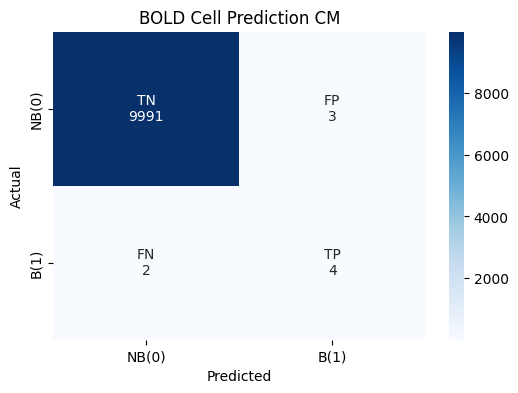


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4
3,1,0,1,1,1
4,0,1,0,0,0
5,0,1,0,0,0
6,0,1,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4
0,1,0,0,0,0
3,1,1,1,1,1


In [19]:
from utils import inferutil
importlib.reload(inferutil)
from utils.inferutil import infer_one

infer_one(trained_model, train_loader, loc=1, disp_max = True, threshold = 0.86, condition = '<', device = DEVICE)


Filename: ../data/val_big/john_hodge_000_1_1.pst.14.xls

--- Sigmoid Probabilities for Bold Cells ---
Cell (0, 0): 0.94057983160018920898
Cell (0, 1): 0.94057983160018920898
Cell (0, 2): 0.94057983160018920898
Cell (0, 3): 0.94057983160018920898
Cell (0, 4): 0.94057983160018920898
Cell (0, 5): 0.94057983160018920898
Cell (0, 6): 0.94057983160018920898
Cell (0, 7): 0.94057983160018920898
Cell (1, 0): 0.91329646110534667969
Cell (1, 1): 0.91329646110534667969
Cell (1, 2): 0.91329646110534667969
Cell (1, 3): 0.91329646110534667969
Cell (1, 4): 0.91329646110534667969
Cell (1, 5): 0.91329646110534667969
Cell (1, 6): 0.91329646110534667969
Cell (1, 7): 0.91329646110534667969
Cell (6, 2): 0.64561289548873901367
Cell (6, 5): 0.90581709146499633789
Cell (6, 6): 0.90581709146499633789
Cell (6, 7): 0.90581709146499633789
Cell (7, 0): 0.80051690340042114258
Cell (7, 1): 0.82966727018356323242
Cell (7, 2): 0.83866888284683227539
Cell (7, 3): 0.77944451570510864258
Cell (7, 5): 0.918966650962829589

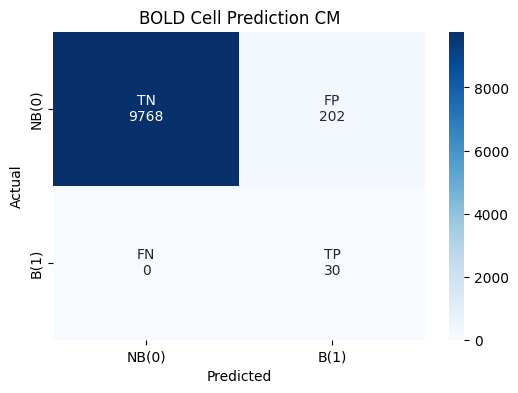


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7
0,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1
8,1,1,0,0,1,1,1,1
9,1,1,1,1,1,1,1,1



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7
0,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1
6,0,0,1,0,0,1,1,1
7,1,1,1,1,0,1,1,1
8,1,0,0,0,0,0,0,0
12,1,0,0,0,0,0,0,0
14,1,0,0,0,0,0,0,0


In [28]:
infer_one(trained_model, val_loader, loc=1, disp_max = True, threshold = 0.95, condition = '<', device = DEVICE)


Filename: ../data/test_big/larry_campbell_000_1_1.pst.231.xls

--- Sigmoid Probabilities for Bold Cells ---
Cell (0, 0): 0.96174234151840209961
Cell (1, 0): 0.93082016706466674805
Cell (2, 0): 0.93255257606506347656
Cell (7, 0): 0.81429231166839599609
Cell (7, 1): 0.96247899532318115234
Cell (7, 2): 0.96247899532318115234
Cell (7, 3): 0.96247899532318115234
Cell (7, 4): 0.96247899532318115234
Cell (7, 5): 0.96247899532318115234
Cell (7, 6): 0.96247899532318115234
Cell (7, 7): 0.96247899532318115234
Cell (8, 0): 0.92328161001205444336
Cell (8, 1): 0.93003243207931518555
Cell (8, 2): 0.93126416206359863281
Cell (8, 3): 0.77212244272232055664
Cell (8, 4): 0.79856175184249877930
Cell (8, 5): 0.85203230381011962891
Cell (8, 6): 0.82610106468200683594
Cell (8, 7): 0.76731288433074951172
Cell (21, 0): 0.95227569341659545898

--- Unique Sigmoid Probabilities ---
Cell (5, 0): 0.68550401926040649414
Cell (8, 7): 0.76731288433074951172
Cell (8, 3): 0.77212244272232055664
Cell (20, 0): 0.77616655

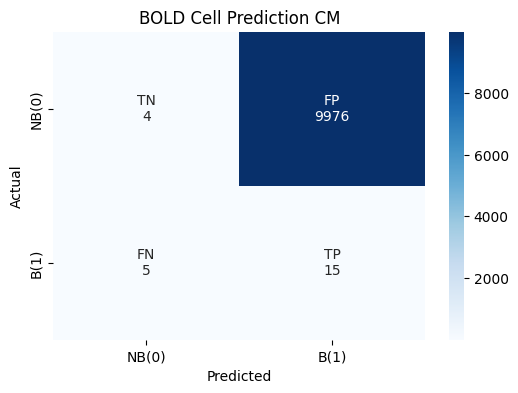


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
8,1,1,1,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
7,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1
21,1,0,0,0,0,0,0,0


In [32]:
infer_one(trained_model, test_loader, loc=1, disp_max = True, threshold = 0.85, condition = '>', device = DEVICE)